In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import alphaOp
import tsOp
import nanOp
import simulate
import cPickle as pickle

In [103]:
# Define constant

bookSize = 20e6

==================================
# Read and check data

### Read file

In [2]:
### checking data
filename1 = 'CafeF.RAW_HSX.Upto01.11.2019.csv'
filename2 = 'CafeF.RAW_HNX.Upto01.11.2019.csv'

In [3]:
df1 = pd.read_csv(filename1)
df1['Exchange'] = 'HSX'
df2 = pd.read_csv(filename2)
df2['Exchange'] = 'HNX'

In [4]:
df = df1.append(df2)

In [5]:
# Length of the data
len(df)

1466769

In [6]:
df = df.rename(columns={"<Ticker>": "Ticker", "<DTYYYYMMDD>": "Date", "<Open>": "Open","<High>": "High","<Low>": "Low","<Close>": "Close", "<Volume>": "Volume"})

In [7]:
# Get unique tickers
tickers = np.unique(df.Ticker.values).astype(str)
# filter for stock ticker only
stock_tickers = []
for ticker in tickers:
    if len(ticker) == 3:
        stock_tickers.append(ticker)
stock_tickers = np.array(stock_tickers)
print 'Number of stock ticker is: ', len(stock_tickers)

Number of stock ticker is:  820


In [8]:
# Get stock df
stock_df = df[df.Ticker.isin(stock_tickers)]

In [38]:
close_df = stock_df.pivot_table(index='Date', columns='Ticker', values='Close')
open_df = stock_df.pivot_table(index='Date', columns='Ticker', values='Open')

In [39]:
close_m = close_df.values
open_m  = open_df.values

### Verify data

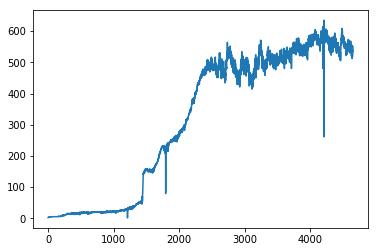

In [37]:
# Quick plot close_m to check for Nun value
plt.plot(np.sum(np.isfinite(close_m), axis=1))
plt.show()

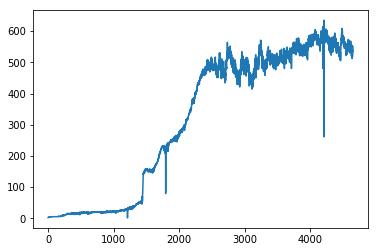

In [40]:
# Quick plot open_m to check for Nun value
plt.plot(np.sum(np.isfinite(open_m), axis=1))
plt.show()

In [26]:
dates  = np.unique(close_df.index)
print 'Number of unique dates is: ', len(dates)

Number of unique dates is:  4651


==================================
# Alpha
* this is only demo, so it is very unrealistic:
    * it does not incorporate T+3
    * it does not incorporate any trading cost
* book size is keep at fixed 20 mil everyday

In [27]:
# Get day to day percentage change
return_m = np.full_like(close_m, np.nan)
return_m[1:] = close_m[1:]/ close_m[:-1] - 1

In [41]:
# Get day to day percentage change
open_return_m = np.full_like(open_m, np.nan)
open_return_m[1:] = open_m[1:]/ open_m[:-1] - 1

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


## Reversion strategy

### Create Alpha
* Alpha based on reversion of past n days.

In [53]:
# Get moving average
import numpy.matlib
alpha = tsOp.movingAverage(-return_m, 3)

In [54]:
# rank by row then normalize
# Formula: max alpha has rank=1, rank = alpha/max_alpha
alpha = alphaOp.groupRank(alpha)

there is no group


In [55]:
# Neutralize by (Rank - Mean Rank of Row)
# thus sum each row =0, 0 dollar exposure
alpha = alphaOp.groupNeutralize(alpha)

there is no group


### Simulate

#### Both Long & Short

In [70]:
# Copy alpha to a temp alpha to simulate
final_alpha = alpha.copy()

# Alpha calculated at end of the day for buy/sell of next day.
# Thus need to shift
final_alpha[1:]= final_alpha[:-1]

# Scale alpha to 20 million booksize
final_alpha = alphaOp.scaleAll(final_alpha, bookSize, nanIsZero=True)

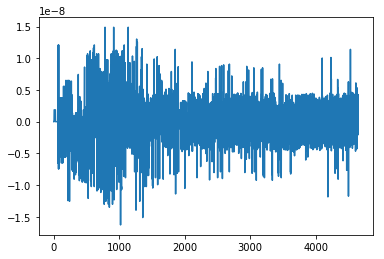

In [71]:
# Plot exposure each day
plt.plot(np.nansum(final_alpha, axis=1))
plt.show()

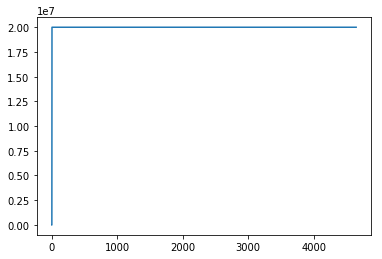

In [65]:
# plot booksize each day by sum of absolute value
plt.plot(np.nansum(np.fabs(final_alpha), axis=1))
plt.show()

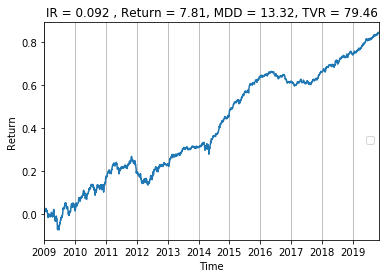


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009    0.013       1.63    9.99        73.39        87       202      47.81
2010    0.129      15.37    5.03        78.84       133       311      57.60
2011    0.024       2.23    7.81        79.70       145       339      52.42
2012    0.043       4.04    6.06        78.65       145       338      50.80
2013    0.128       7.99    1.47        82.03       144       336      56.00
2014    0.159      16.53    5.51        81.65       153       355      60.73
2015    0.245      16.10    1.88        81.70       153       357      63.71
2016   -0.040      -2.05    5.42        79.57       161       375      50.60
2017    0.093       4.66    2.45        78.85       170       397      54.80
2018    0.129       8.14    1.84        80.33       167       391      57.20
2019    0.247      12.19    0.82        79.48       163       379      56.25
Total   0.092       7.81   13.32        79.46       152       354      55.2

In [66]:
# Simulate our strategy
# Use date from 2009
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(final_alpha[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(final_alpha[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

#### Only long

In [67]:
# Copy alpha
final_long_alpha = alpha.copy()
# Remove negative (short)
final_long_alpha[final_long_alpha < 0] = 0

# Alpha calculated at end of the day for buy/sell of next day.
# Thus need to shift
final_long_alpha[1:]= final_long_alpha[:-1]

# Scale alpha to 20 million booksize
final_long_alpha = alphaOp.scaleAll(final_long_alpha, bookSize, nanIsZero=True)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


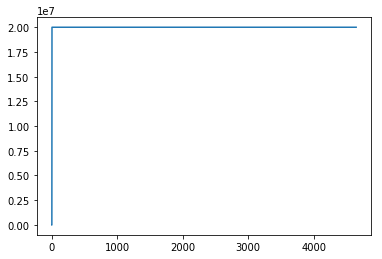

In [69]:
# Plot exposure each day
plt.plot(np.nansum(final_long_alpha, axis=1))
plt.show()

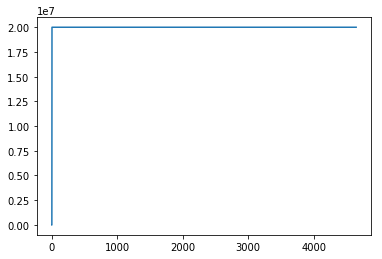

In [73]:
# plot booksize each day
plt.plot(np.nansum(np.fabs(final_long_alpha), axis=1))
plt.show()

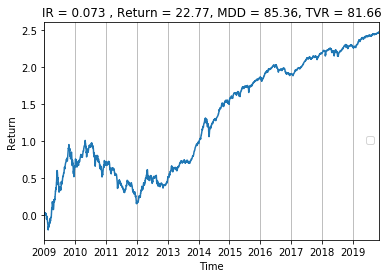


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009    0.117      66.79   43.30        76.60        44       101      57.37
2010    0.009       4.51   49.27        81.35        67       156      53.60
2011   -0.161     -53.85   57.13        79.64        73       170      36.29
2012    0.095      31.27   24.79        80.17        73       170      53.20
2013    0.232      48.88    8.07        84.89        72       169      63.20
2014    0.185      58.15   24.91        84.78        77       178      69.23
2015    0.163      30.65    9.53        83.94        77       179      60.89
2016    0.028       4.46   14.53        81.84        81       188      55.38
2017    0.263      28.25    4.95        81.62        85       199      62.00
2018    0.041       8.21   11.26        81.78        84       196      59.60
2019    0.205      22.98    2.51        81.69        82       190      60.10
Total   0.073      22.77   85.36        81.66        76       177      57.3

In [74]:
# Simulate our strategy
# Use date from 2009
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(final_long_alpha[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(final_long_alpha[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

## Momentum strategy

### Create alpha
* calculate last 250 days average return, excluding last 20 days due to 20 day reversion effect
* in general stocks exhibit short term reversion but long term momentum

In [76]:
alpha1 = tsOp.movingSum(tsOp.delay(return_m, 20), 230)

In [77]:
# rank 
alpha1 = alphaOp.groupRank(alpha1)

there is no group


In [79]:
# Neutralize for 0 dollar exposure
alpha1 = alphaOp.groupNeutralize(alpha1)

there is no group


### Simulate

#### Both long and short

In [82]:
# Copy alpha to a temp alpha to simulate
final_alpha1 = alpha1.copy()

# Alpha calculated at end of the day for buy/sell of next day.
# Thus need to shift
final_alpha1[1:]= final_alpha1[:-1]

# Scale alpha to 20 million booksize
final_alpha1 = alphaOp.scaleAll(final_alpha1, bookSize, nanIsZero=True)

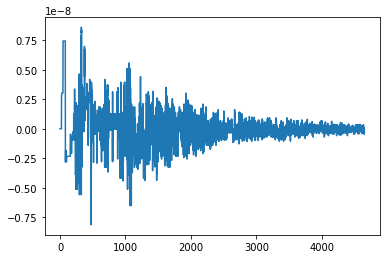

In [83]:
# Plot exposure each day
plt.plot(np.nansum(final_alpha1, axis=1))
plt.show()

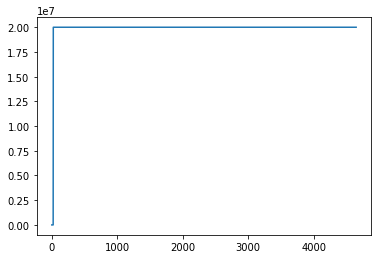

In [84]:
# plot booksize each day by sum of absolute value
plt.plot(np.nansum(np.fabs(final_alpha1), axis=1))
plt.show()

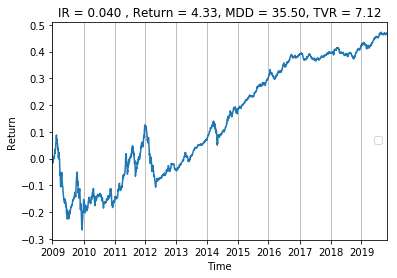


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009   -0.083     -18.20   35.50         6.02       229       695      51.39
2010    0.018       2.46    7.33         6.49       230       656      52.80
2011    0.170      27.49   11.38         6.21       244       587      65.73
2012   -0.144     -15.89   22.96         8.53       239       584      51.20
2013    0.248      11.81    3.47         8.46       240       588      64.00
2014    0.110      10.81    9.02         6.47       248       561      63.56
2015    0.302      12.14    1.16         7.48       241       582      63.71
2016    0.178       8.79    3.61         6.58       241       574      60.56
2017    0.019       0.71    2.93         6.92       241       570      53.20
2018    0.061       2.76    4.16         7.57       241       561      53.60
2019    0.127       5.33    2.36         7.65       241       561      55.29
Total   0.040       4.33   35.50         7.12       241       572      57.7

In [85]:
# Simulate our strategy
# Use date from 2009
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(final_alpha1[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(final_alpha1[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

#### Only long

In [95]:
# Copy alpha
final_long_alpha1 = alpha1.copy()
# Remove negative (short)
final_long_alpha1[final_long_alpha1 < 0] = 0

# Alpha calculated at end of the day for buy/sell of next day.
# Thus need to shift
final_long_alpha1[1:]= final_long_alpha1[:-1]

# Scale alpha to 20 million booksize
final_long_alpha1 = alphaOp.scaleAll(final_long_alpha1, bookSize, nanIsZero=True)

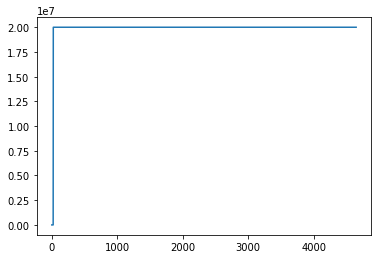

In [96]:
# Plot exposure each day
plt.plot(np.nansum(final_long_alpha1, axis=1))
plt.show()

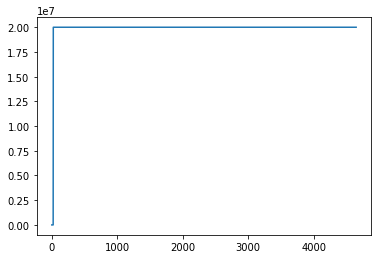

In [97]:
# Plot booksize each day
plt.plot(np.nansum(np.fabs(final_long_alpha1), axis=1))

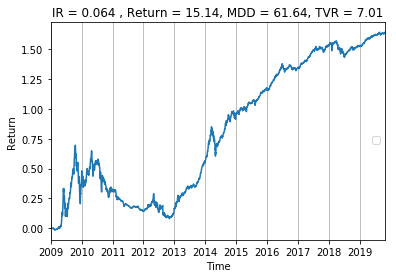


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009    0.084      39.91   49.09         5.50       110       251      57.37
2010   -0.018      -7.32   39.06         6.46       114       258      48.40
2011   -0.203     -17.96   18.26         6.40       137       316      36.29
2012    0.001       0.14   20.93         8.08       120       280      53.20
2013    0.282      41.18    5.21         8.01       120       281      65.20
2014    0.145      39.28   24.64         7.17       121       281      65.18
2015    0.198      22.81    4.65         6.98       121       281      60.08
2016    0.153      16.91    7.06         6.35       121       281      62.15
2017    0.220      18.75    4.87         6.95       121       281      62.00
2018   -0.000      -0.07   13.56         7.65       121       281      54.80
2019    0.191      12.48    2.31         7.69       121       281      57.69
Total   0.064      15.14   61.64         7.01       121       281      56.5

In [98]:
# Simulate our strategy
# Use date from 2009
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(final_long_alpha1[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(final_long_alpha1[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

* momentum is a longer term strategy compared to reversion
* that's why it has way lower turnover (<10%) compared to reversion turnover (> 70%)
* since it has low turnover, using close-to-close return or open-to-open return did not make much difference to the result
because it is not very sensitive to small daily changes (unlike reversion)

* a possible idea could be combining this 2 signals together to diversify and achieve mid level turnover level

## Combined alpha

* combining reversion and momentum alpha: just simple equal weight 2 portfolio

#### Combined short and long

In [100]:
combined_alpha = final_alpha + final_alpha1

In [110]:
# Scale to bookSize
combined_alpha = alphaOp.scaleAll(combined_alpha, bookSize, nanIsZero=True)

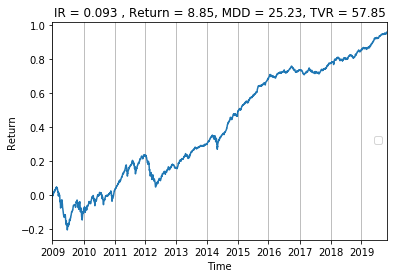


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009   -0.059     -10.27   25.23        52.17       120       612      51.00
2010    0.094      12.58    7.16        58.03       149       576      61.20
2011    0.196      20.71    7.93        56.47       190       587      65.73
2012   -0.065      -6.80   18.65        58.13       167       520      53.60
2013    0.255      14.22    2.84        60.24       170       538      62.80
2014    0.172      18.63    8.34        55.91       202       580      65.99
2015    0.370      19.83    1.33        60.02       178       556      69.35
2016    0.105       5.09    3.55        59.44       177       518      54.98
2017    0.083       4.00    3.44        58.15       183       530      54.40
2018    0.139       7.83    2.21        59.16       185       514      56.40
2019    0.305      12.58    1.15        58.79       184       516      58.17
Total   0.093       8.85   25.23        57.85       178       540      59.4

In [111]:
# Simulate
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(combined_alpha[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(combined_alpha[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

#### Combined long only

In [107]:
combined_long_alpha = final_long_alpha + final_long_alpha1

In [112]:
# Scale to bookSize
combined_long_alpha = alphaOp.scaleAll(combined_long_alpha, bookSize, nanIsZero=True)

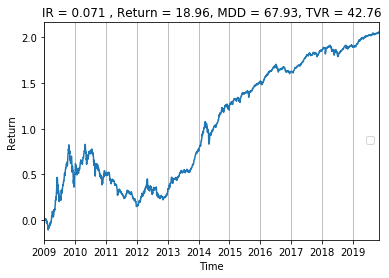


           IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90 Winning(%)
2009    0.105      53.35   46.19        39.84        83       237      56.97
2010   -0.003      -1.40   44.16        42.49       106       284      50.80
2011   -0.177     -35.91   37.58        42.17       153       449      35.48
2012    0.061      15.70   22.86        42.41       130       337      50.00
2013    0.258      45.03    6.64        44.56       125       331      64.40
2014    0.169      48.71   24.62        44.02       125       334      68.42
2015    0.181      26.73    6.96        43.76       132       348      61.69
2016    0.083      10.68   10.22        42.59       138       357      58.57
2017    0.257      23.50    4.80        42.57       142       365      63.20
2018    0.024       4.07   12.41        42.97       143       370      56.80
2019    0.219      17.73    1.88        43.01       142       372      59.62
Total   0.071      18.96   67.93        42.76       133       356      56.8

In [113]:
# Simulate
simStartDi = np.where(dates > 20090101)[0][0]

pnl, tvr = simulate.fastSim(combined_long_alpha[simStartDi:],
                            return_m = return_m[simStartDi:],
                            buying_fee = 0./100,
                            selling_fee = 0./100)

alphaOp.alphaStatSummary(combined_long_alpha[simStartDi:],
                         pnl, tvr,
                         dates[simStartDi:],
                         bookSize=bookSize,
                         isAnnualSummary = True,
                         plot=True)

* more ideas ?? 
 * technical analysis
 * using order book data (best bid/ best ask)
 * using volume to detect
 * trade faster? using intraday data to incorprate in alpha (but where to get data??)
 
* more to consider:
 * T+3 and cost
 * liquidity of each stock (probably cannot trade all 800 stocks like this, need to choose top liquidity)
 * minimum lot per stock to trade
 * volume constraint: we cannot trade, for example, 50% of the daily volume of a stock, it will lead to impact (getting bad
 price, revealing intention, etc), so we should constraint it to 5-10% of daily volume (approx by last 20 days average)